# scikit-learn scratchpad

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report
import os
from PIL import Image
from dataclasses import dataclass
import importlib

import lib
from lib import Rect, CustomDataset, Session, Data, TrainingResult

In [2]:
importlib.reload(lib)

<module 'lib' from 'C:\\Users\\roland\\dev\\fun-pytorch\\sc-screenshot-classify\\lib.py'>

In [3]:
EXAMPLES = True
CROP_REGION = Rect(left=165, top=1192, width=2117, height=211)

In [8]:
if EXAMPLES:
    r = Rect(left=165, top=1192, width=2117, height=211)
    print(r.right, r.bottom)
    r = None

608 2421


In [4]:
def make_criterion(): return nn.CrossEntropyLoss()
def make_optimizer(model): return optim.Adam(model.parameters(), lr=0.001)

sess = Session(
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    crop_region=CROP_REGION,
    criterion=make_criterion,
    optimizer=make_optimizer,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

data = Data(
    dataset=CustomDataset('data/screenshots', transform=sess.transform, crop_rect=CROP_REGION),
    batch_size=32,
    shuffle=True,
)

if EXAMPLES:
    model = models.resnet34()
    result = lib.train(sess, data, model, num_epochs=9)

Epoch 1/9 - Loss: 1.4954
Epoch 2/9 - Loss: 0.1269
Epoch 3/9 - Loss: 0.0050
Epoch 4/9 - Loss: 0.0024
Epoch 5/9 - Loss: 0.0175
Epoch 6/9 - Loss: 0.0025
Epoch 7/9 - Loss: 0.0031
Epoch 8/9 - Loss: 0.0011
Epoch 9/9 - Loss: 0.0036


In [5]:
lib.evaluate(result, sess.device, data.dataset.classes)

              precision    recall  f1-score   support

       other       1.00      1.00      1.00        10
     starmap       1.00      1.00      1.00         5

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



let's save the model for later

In [20]:
torch.save(model.state_dict(), 'resnet34_state_dict_v3.pth')

Let's try to use the model now.

In [82]:
import torch
from torchvision import transforms
from PIL import Image

def load_model(model_path, device='cpu'):
    model = models.resnet34()
    model.fc = nn.Linear(model.fc.in_features, 2)
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=False))
    model.eval()
    return model.to(device)

# Preprocessing (must match training preprocessing)
def preprocess_image(image_path):    
    img = Image.open(image_path).convert('RGB')    
    r = CROP_REGION
    img = img.crop((r.left, r.top, r.right, r.bottom)) 
    return sess.transform(img).unsqueeze(0)  # Add batch dimension

# Example usage
def example_usage(image_path, dict_path):
    model = load_model(dict_path)
    input_tensor = preprocess_image(image_path)
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        predicted_class = torch.argmax(probabilities).item()
        return ["other", "starmap"][predicted_class]


In [56]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML

In [83]:
image_paths = [
    'E:/bin/StarCitizen/LIVE/ScreenShots/ScreenShot-2024-05-11_21-58-40-1A3.jpg',
    'E:/bin/StarCitizen/LIVE/ScreenShots/ScreenShot-2024-05-12_00-09-07-EF4.jpg',
    r"E:\bin\StarCitizen\LIVE\ScreenShots\ScreenShot-2024-07-31_01-13-41-B9A.jpg",
    r"E:\bin\StarCitizen\LIVE\ScreenShots\ScreenShot-2024-08-13_23-34-21-1CC.jpg",
    r"E:\bin\StarCitizen\LIVE\ScreenShots\ScreenShot-2025-03-06_22-49-40-3A1.jpg",
    r"E:\bin\StarCitizen\LIVE\ScreenShots\ScreenShot-2025-03-06_23-52-52-0D2.jpg"
]

df = pd.DataFrame({
    'Image': image_paths,
    'Prediction(v2)': [example_usage(path, 'resnet34_state_dict_v2.pth') for path in image_paths],
    'Prediction(v3)': [example_usage(path, 'resnet34_state_dict_v3.pth') for path in image_paths]
})

Prediction: v2=other v3=other


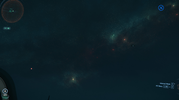

Prediction: v2=other v3=other


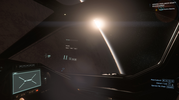

Prediction: v2=other v3=other


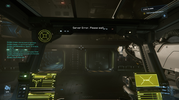

Prediction: v2=starmap v3=starmap


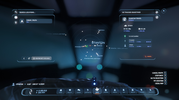

Prediction: v2=starmap v3=starmap


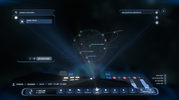

Prediction: v2=starmap v3=starmap


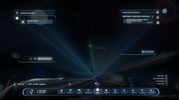

In [84]:
def display_image(path):
    img = Image.open(path)
    new_size = (np.array(img.size)*0.07).astype(int)
    display(img.resize(new_size, Image.LANCZOS))

for index, row in df.iterrows():
    print(f"Prediction: v2={row['Prediction(v2)']} v3={row['Prediction(v3)']}")
    display_image(row['Image'])